In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from palettable.colorbrewer.sequential import GnBu_9

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39685/status,
Dashboard: /proxy/39685/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46767,Workers: 4
Dashboard: /proxy/39685/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:38779,Total threads: 4
Dashboard: /proxy/34209/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:43519,


In [2]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')
mask = mask['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu']
hu = hu.sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90,-50.1,.1))), 1, np.nan)
land_ice_mask = land_ice_mask.interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, 
                                     land_ice_mask['lon'] + 360, 
                                     land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon':'_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj':sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj':'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_lin = xr.open_dataset('../data/smooth_div_line.nc')
div_lin = div_lin['__xarray_dataarray_variable__']

Load reanalysis and CMIP6 multimodel mean

In [3]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
path_psl = glob.glob('../data/cmip6-regridded/psl_hist*')
uas_cmip = {}; vas_cmip = {}; psl_cmip = {}
uas_cmip['mrm'] = xr.open_dataset('../data/uas-monthly-1979_2015-reanalysis.nc')['uas'].mean('time')
vas_cmip['mrm'] = xr.open_dataset('../data/vas-monthly-1979_2015-reanalysis.nc')['vas'].mean('time')
psl_cmip['mrm'] = xr.open_dataset('../data/psl-monthly-1979_2015-reanalysis.nc')['psl'].mean('time')
for i in range(len(path_uas)):
    n = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[n] = xr.open_dataset(path_uas[i])['uas']
    uas_cmip[n] = uas_cmip[n].sel(time = slice('1979-01-01', '2015-01-01'))
    uas_cmip[n] = uas_cmip[n].mean('time')
    
    n = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[n] = xr.open_dataset(path_vas[i])['vas']
    vas_cmip[n] = vas_cmip[n].sel(time = slice('1979-01-01', '2015-01-01'))
    vas_cmip[n] = vas_cmip[n].mean('time')
    
    n = path_psl[i].split('/')[-1].split('_')[-1].split('.')[0]
    psl_cmip[n] = xr.open_dataset(path_psl[i])['psl']
    psl_cmip[n] = psl_cmip[n].sel(time = slice('1979-01-01', '2015-01-01'))
    psl_cmip[n] = psl_cmip[n].mean('time')
model_keys = list(uas_cmip.keys())

In [4]:
wsp = {}
for k in model_keys:
    wsp[k] = np.sqrt(uas_cmip[k]**2 + vas_cmip[k]**2)

In [5]:
ver_levs = xr.DataArray([np.nan, 95, 45, 49, 91, 91, 91, 62, 32, 33, 49, 64, 21, 73, 79, 85, 81, 47, 80, 47], dims = 'model', coords = {'model':model_keys})

In [6]:
hor_resl = xr.DataArray([np.nan, 100, 100, 250, 250, 100, 250, 100, 250, 250, 250, 100, 100, 250, 100, 100, 100, 100, 100, 500], dims = 'model', coords = {'model':model_keys})

In [9]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas_cmip[k]['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas_cmip[k]))
for i in range(len(uas_cmip[k]['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas_cmip[k]['lat'], 'lon':uas_cmip[k]['lon']})

In [10]:
wsp_ave = {}
for k in model_keys:
    wsp_ave[k] = (wsp[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [11]:
wsp_bias = wsp_ave[model_keys[1]] - wsp_ave['mrm']
for k in model_keys[2:]:
    wsp_bias = xr.concat([wsp_bias, wsp_ave[k] - wsp_ave['mrm']], dim = 'model')
wsp_bias['model'] = model_keys[1:]

In [12]:
uas_ave = {}
for k in model_keys:
    uas_ave[k] = (uas_cmip[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [13]:
uas_bias = uas_ave[model_keys[1]] - uas_ave['mrm']
for k in model_keys[2:]:
    uas_bias = xr.concat([uas_bias, uas_ave[k] - uas_ave['mrm']], dim = 'model')
uas_bias['model'] = model_keys[1:]

In [14]:
vas_ave = {}
for k in model_keys:
    vas_ave[k] = (vas_cmip[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [15]:
vas_bias = vas_ave[model_keys[1]] - vas_ave['mrm']
for k in model_keys[2:]:
    vas_bias = xr.concat([vas_bias, vas_ave[k] - vas_ave['mrm']], dim = 'model')
vas_bias['model'] = model_keys[1:]

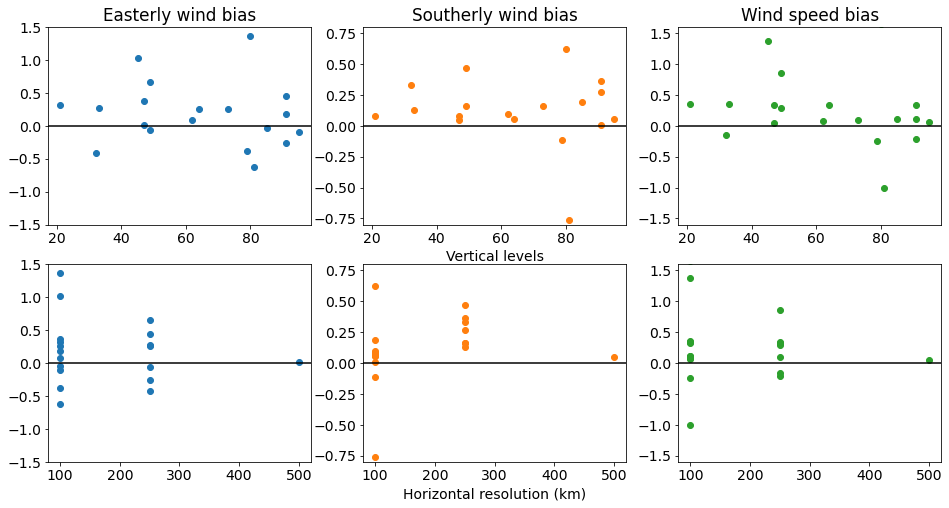

In [23]:
plt.rcParams['font.size'] = 14
fig, axs = plt.subplots(2, 3, figsize = (16, 8))
axs[0,0].axhline(color = 'k')
axs[0,1].axhline(color = 'k')
axs[0,2].axhline(color = 'k')
axs[1,0].axhline(color = 'k')
axs[1,1].axhline(color = 'k')
axs[1,2].axhline(color = 'k')
axs[0,0].set_ylim(-1.5,1.5)
axs[0,1].set_ylim(-.8,.8)
axs[0,2].set_ylim(-1.6,1.6)
axs[1,0].set_ylim(-1.5,1.5)
axs[1,1].set_ylim(-.8,.8)
axs[1,2].set_ylim(-1.6,1.6)
for k in ver_levs['model'][1:]:
    axs[0,0].scatter(ver_levs.sel(model = k), -uas_bias.sel(model = k), color = 'C0')
    axs[0,1].scatter(ver_levs.sel(model = k), vas_bias.sel(model = k), color = 'C1')
    axs[0,2].scatter(ver_levs.sel(model = k), wsp_bias.sel(model = k), color = 'C2')
    
    axs[1,0].scatter(hor_resl.sel(model = k), -uas_bias.sel(model = k), color = 'C0')
    axs[1,1].scatter(hor_resl.sel(model = k), vas_bias.sel(model = k), color = 'C1')
    axs[1,2].scatter(hor_resl.sel(model = k), wsp_bias.sel(model = k), color = 'C2')
axs[0,1].set_xlabel('Vertical levels')
axs[1,1].set_xlabel('Horizontal resolution (km)')
axs[0,0].set_title('Easterly wind bias')
axs[0,1].set_title('Southerly wind bias')
axs[0,2].set_title('Wind speed bias')
plt.savefig('../results/biases.jpg', bbox_inches = 'tight')